In [1]:
# Importing the libraries
import re
import os
import time
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle 

from tqdm import tqdm        # for statusBar
from bs4 import BeautifulSoup

# nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import tweepy
import twitter_credentials       # python file in same directory containing twitter credentials
from tweepy import OAuthHandler  # Authenticate machine to access twitter server

In [2]:
# Initializing the access 
auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)

In [3]:
# search tokens 
args = ['global warming', 'india'];                
api = tweepy.API(auth,timeout=10)

In [4]:
# Fetching the tweets
list_tweets = []
query = args[0]

# fetching first 100 tweets
for status in tweepy.Cursor(api.search, q=query+" -filter:retweets", lang='en', result_type='recent').items(100):
    list_tweets.append(status.text)

In [5]:
list_tweets[1]

'So let me get this straight: China is out here harvesting people for organs and torturing them, yet the only stuff… https://t.co/dtwsc0NedU'

In [6]:
stop_words = stopwords.words('english')

# As 'no', 'nor', 'not' should not be considered as stop words, we'll remove it.
for i in stop_words: 
    if(i in ['no', 'nor', 'not']) : 
        stop_words.remove(i)

In [7]:
# Expanding contractions - https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [8]:
def process_tweets(list_tweets):
    pre_process_tweets = []

    for twt in tqdm(list_tweets):
        twt = re.sub(r"http\S+", "", twt)                 # http links
        twt = BeautifulSoup(twt, 'lxml').get_text()       # no need here as tweepy does it pretty well
        twt = decontracted(twt)
        twt = re.sub("\S*\d\S*", "", twt).strip()         # any single digit
        twt = re.sub('[^A-Za-z]+', ' ',twt)               # anything other than text

        twt = ' '.join(e.lower() for e in twt.split() if e.lower() not in stop_words)
        pre_process_tweets.append(twt.strip())
    return pre_process_tweets

In [9]:
preprocessed_tweets = process_tweets(list_tweets)
preprocessed_tweets[1]

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1916.86it/s]


'let get straight china harvesting people organs torturing yet stuff'

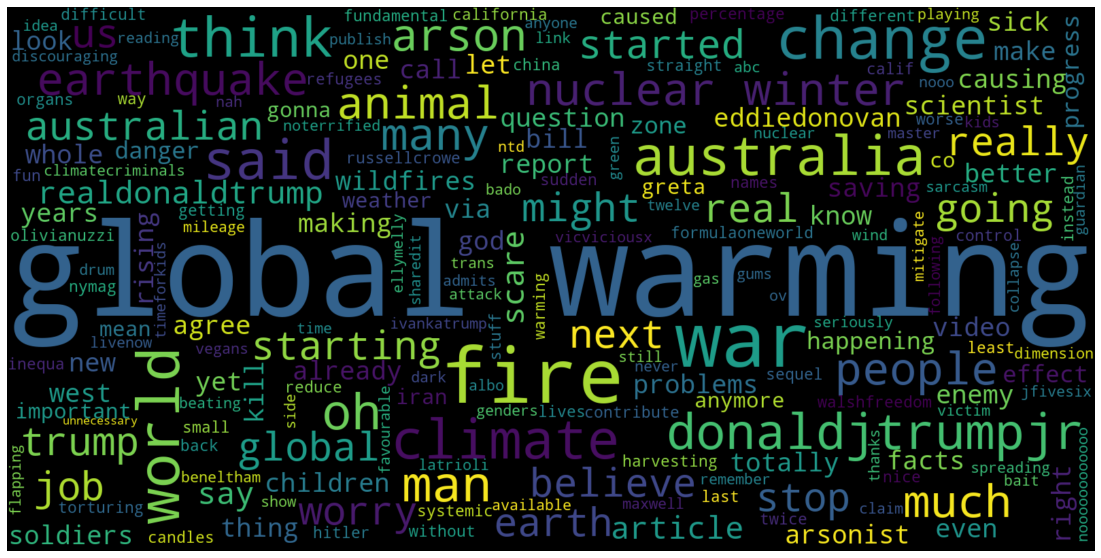

In [10]:
# !pip install wordcloud
from wordcloud import WordCloud

twts_wc = pd.Series(preprocessed_tweets).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(twts_wc)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Building Custom Classifier - Positive and negative tweets

**Dataset**: http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip <br> **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

In [18]:
directory = os.getcwd()+"\\data\\input"
dataset_filename = os.listdir(os.getcwd()+"\\data\\input")[0]
dataset_path = os.path.join(directory,dataset_filename)

DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]

df = pd.read_csv(dataset_path, encoding = "ISO-8859-1" , names=DATASET_COLUMNS)
df.shape

(1600000, 6)

In [19]:
# taking only a random sample for our analysis = 20 % as it's a huge dataset
df = df.sample(frac=0.25, replace=True, random_state=1)
X,y = df.text, df.target

In [20]:
X = process_tweets(X.to_list())

100%|████████████████████████████████████████████████████████████████████████| 400000/400000 [02:03<00:00, 3251.03it/s]


In [24]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

y = y.apply(lambda x: decode_sentiment(x))

In [25]:
# Creating Tf-Idf model 
vectorizer = TfidfVectorizer(max_features = 2000, min_df = 3, max_df = 0.6, stop_words = stop_words)
tweets = vectorizer.fit_transform(X).toarray()

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(tweets, y, test_size = 0.20, random_state = 7)

In [28]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='liblinear', class_weight="balanced", 
                             random_state=7, max_iter=1000)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
# Testing model performance
predictions = classifier.predict(X_test)

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)
cm

array([[29954, 10109],
       [ 8357, 31580]], dtype=int64)

In [32]:
# Saving our classifier
with open('classifier.pickle','wb') as f:
    pickle.dump(classifier,f)
    
# Saving the Tf-Idf model
with open('tfidfmodel.pickle','wb') as f:
    pickle.dump(vectorizer,f)

In [ ]:
# Loading the vectorizer and classfier
with open('classifier.pickle','rb') as f:
    classifier = pickle.load(f)
    
with open('tfidfmodel.pickle','rb') as f:
    tfidf = pickle.load(f)    

In [61]:
# making predictions 
pos_total = 0
pos_tweets = []
neg_total = 0
neg_tweets = []

for tweet in list_tweets:
    sent = classifier.predict(tfidf.transform([tweet]).toarray())
    if sent[0] == 'POSITIVE':
        total_pos += 1
        pos_tweets.append(tweet)
    else:
        total_neg += 1
        neg_tweets.append(tweet)

## Results
### Postive tweets

In [62]:
pos_tweets[20:30]

['@IlhanMN Arson in support of the fraud that is global warming.Australian bush fires come to mind.',
 '@KnightOfNI5 @LNEnriquez 😂😂😂 Science says global warming started the fires in Australia...but the authorities have arrested 180 arsonists.',
 'Realising that #ww3 will kill us before global warming can 🤡 #IranvsUSA #WWIII https://t.co/2Bs9EKfDTa',
 '@MorganRalston GLOBAL WARMING UN collects billions..',
 '@StanGrantMOF I think we def are in WW111 already. The enemy is global warming &amp; the soldiers are the climate effec… https://t.co/ZoNWWsQ5qa',
 'The only type of man made global warming there is... https://t.co/YpzE69NL4m',
 'Philly’s average temperatures are rising, along with the overall global trend https://t.co/vzsATuts0X via @phillyinquirer',
 'You all better vote next election my family told me global warming isn’t real',
 "@oh_marple @JRinPueblo Anything with 'nuke' in it, is inherently extremely dangerous. The threat of Climate Change/… https://t.co/uBFyCWG0N0",
 '@franc

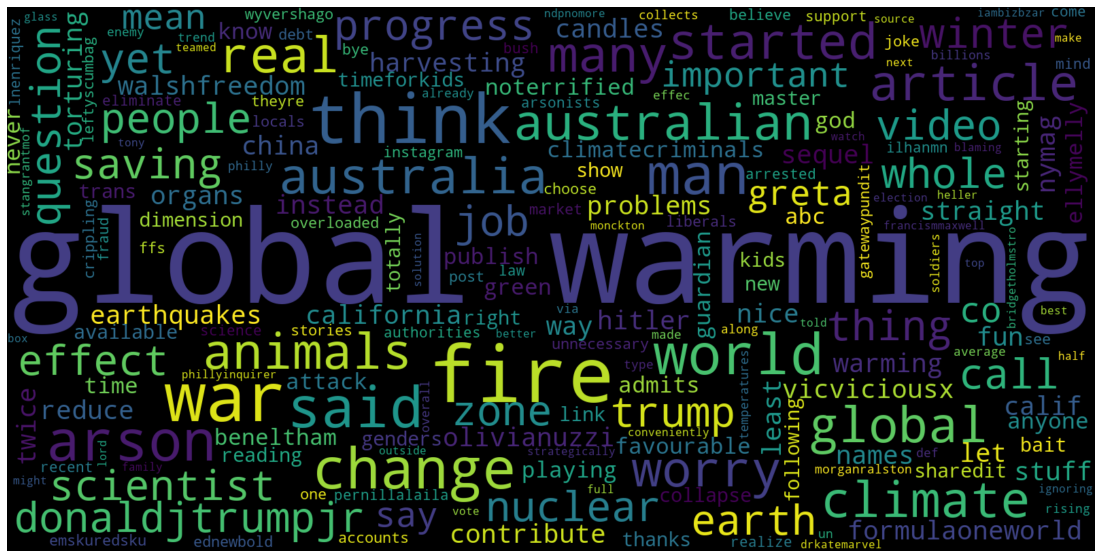

In [53]:
twts_wc = pd.Series(pos_tweets).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(twts_wc)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Negative Tweets

In [63]:
neg_tweets[20:30]

['@RichardEngel We might have to stop and swallow this so there is no war..if there is another war the world will be… https://t.co/NOhPeVnoj9',
 "@slinganswers @notstudyingrn No, the Weather Channel isn't even about weather anymore. It all about extraneous prog… https://t.co/6t6SPVztXZ",
 '@DonaldJTrumpJr This IS what global warming caused by oil and red mest looks like',
 'I have a feeling that @realDonaldTrump and iran wont go to the war because if they do then the world is just f***ed… https://t.co/GCyT7TiGVz',
 '@wvjoe911 @HrhOrchid The same Inhofe that held a snowball claiming there is no global warming?',
 "@ABC7 it's hard to make people believe it's part of global warming when you have so many people starting the fires",
 'Global warming is not an issue anymore https://t.co/CjCXEJzS3F',
 '@Asimanwarhere @ClimateBen It will be a nuclear winter that will stop global warming. Nuclear war in Iran is coming.',
 'Keep thinking bout how the world is gonna end in 10 years cuz of global 

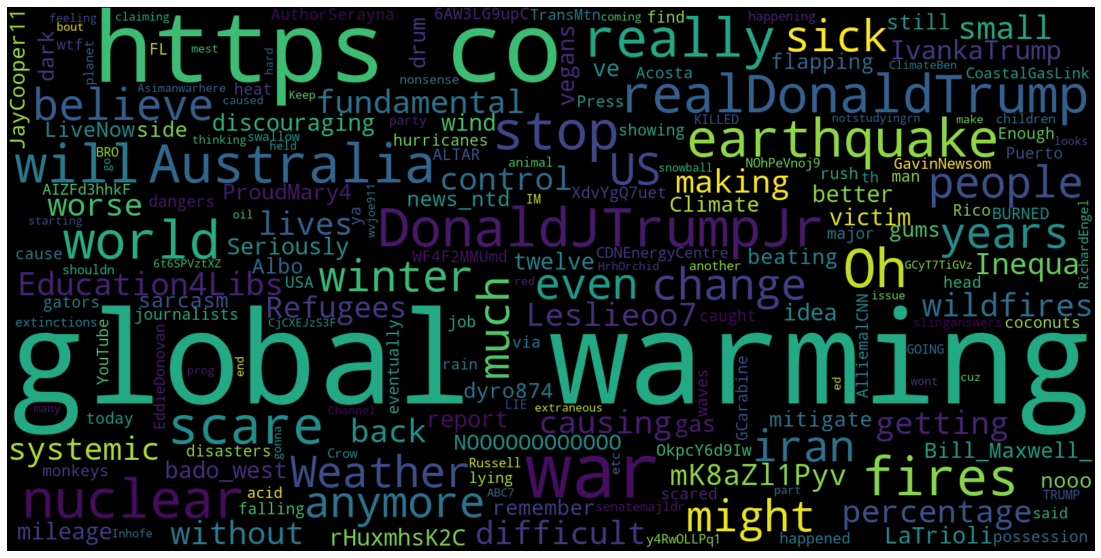

In [64]:
twts_wc = pd.Series(neg_tweets).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(twts_wc)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [65]:
sample = ["You are awesome, have a good life"]
sample = tfidf.transform(sample).toarray()
sentiment = clf.predict(sample)
sentiment

array(['POSITIVE'], dtype=object)